# Network-Flow model: constraint-style LP with Python/Gurobi
## [Jon Lee](https://sites.google.com/site/jonleewebpage/home), 10/20/2020


The model that we work with is
\begin{align*}
z = \min~& \sum_{e \in \mathcal{A}} c_e x_e\\
&\sum_{e\in \mathcal{A} ~:~ t(e)=v} x_e - \sum_{e\in \mathcal{A} ~:~ h(e)=v} x_e 
= b_v,~ \mbox{ for } v \in \mathcal{N};\\
& 0 \leq x_{e} \leq u_e,~ \mbox{ for } e \in \mathcal{A}.\\
\end{align*}

References:

* Jon Lee, "A First Course in Linear Optimization", Fourth Edition (Version 4.05), Reex Press, 2013-22.

MIT License

Copyright (c) 2020 Jon Lee

Permission is hereby granted, free of charge, to any person obtaining a copy 
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [1]:
%reset -f
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import networkx as nx

class StopExecution(Exception):
    def _render_traceback_(self):
        pass

In [2]:
# Some toy data
Nodes, Supply = gp.multidict({
    1: [12.],
    2: [6.],
    3: [-2.],
    4: [0.],
    5: [-9.],
    6: [-7.]})

Arcs, Capacity, Cost = gp.multidict({
    (1,2): [6., 2],
    (1,3): [8., -5],
    (2,4): [5., 3],
    (2,5): [7., 12],
    (3,5): [5., -9],
    (4,5): [8., 2],
    (4,6): [5., 0],
    (5,6): [5., 4]})

In [3]:
model = gp.Model()
x = model.addVars(Arcs)
model.setObjective(sum(Cost[i,j]*x[i,j] for (i,j) in Arcs), GRB.MINIMIZE)
FlowConservationConstraints = model.addConstrs(x.sum(i, '*') - x.sum('*', i) 
                                               == Supply[i] for i in Nodes)
CapacityConstraints = model.addConstrs(x[i,j] <= Capacity[i,j] for (i,j) in Arcs)


Using license file C:\Users\jonxlee\gurobi.lic
Academic license - for non-commercial use only - expires 2021-03-20


In [4]:
model.optimize()
if model.status != GRB.Status.OPTIMAL:
    print("***** Gurobi solve status:", model.status)
    print("***** This is a problem. Model does not have an optimal solution")
    raise StopExecution
print(" ")
print("***** Flows:")
for (i,j) in Arcs: print("x[",i,",",j,"]=",round(x[i,j].X,4), 
                         ",   Capacity[",i,",",j,"]=",Capacity[i,j])

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 14 rows, 8 columns and 24 nonzeros
Model fingerprint: 0x4079af9d
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 1e+01]
Presolve removed 14 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.5000000e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.500000000e+01
 
***** Flows:
x[ 1 , 2 ]= 5.0 ,   Capacity[ 1 , 2 ]= 6.0
x[ 1 , 3 ]= 7.0 ,   Capacity[ 1 , 3 ]= 8.0
x[ 2 , 4 ]= 5.0 ,   Capacity[ 2 , 4 ]= 5.0
x[ 2 , 5 ]= 6.0 ,   Capacity[ 2 , 5 ]= 7.0
x[ 3 , 5 ]= 5.0 ,   Capacity[ 3 , 5 ]= 5.0
x[ 4 , 5 ]= 0.0 ,   Capacity[ 4 , 5 ]= 8.0
x[ 4 , 6 ]= 5.0 ,   Capacity[ 4 , 6 ]= 5.0
x[ 

<IPython.core.display.Javascript object>


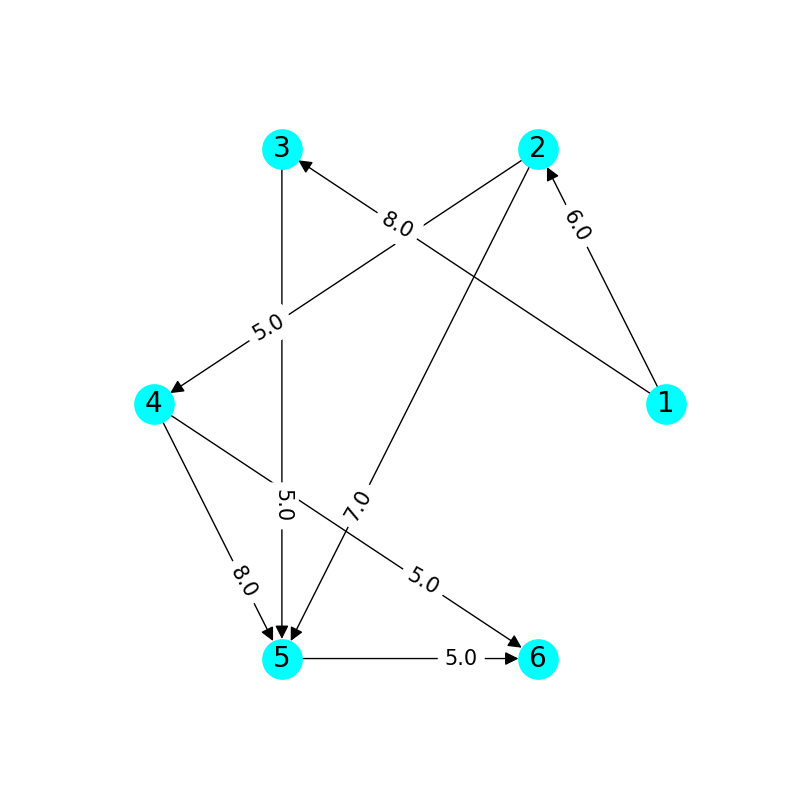

Network with node labels and capacities


In [5]:
G = nx.DiGraph()
G.add_nodes_from(Nodes)
G.add_edges_from(Arcs)
plt.figure(figsize=(8,8))
edge_labels=nx.draw_networkx_edge_labels(G,edge_labels=Capacity,
    pos=nx.shell_layout(G), label_pos=0.3, font_size=15)
nx.draw_shell(G, with_labels=True, node_color='cyan', node_size=800, 
    font_size=20, arrowsize=20)
print("Network with node labels and capacities")

<IPython.core.display.Javascript object>


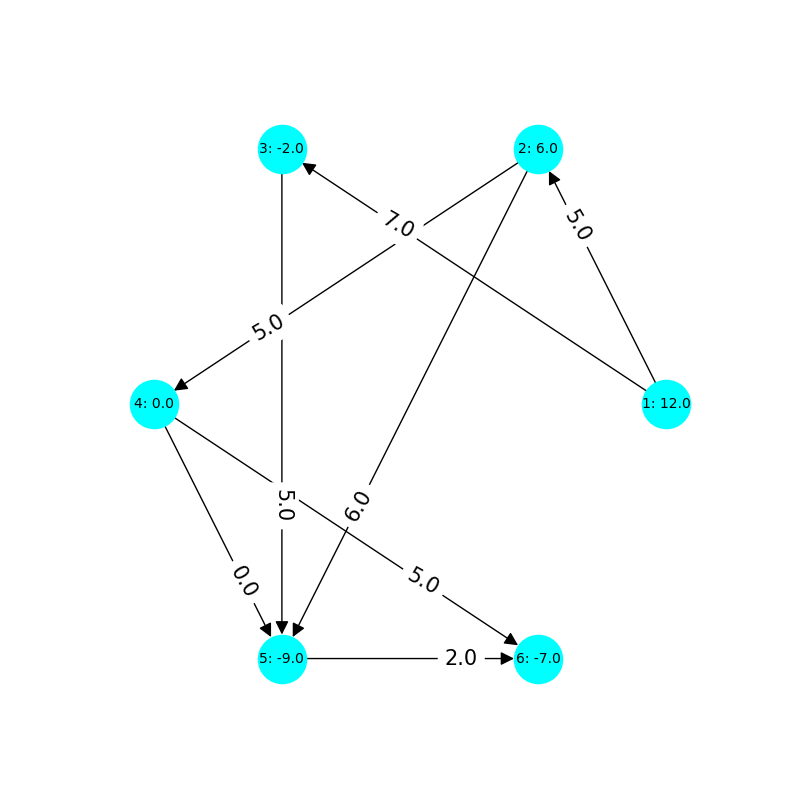

Network with supplies and flows:


In [6]:
Supply_label={}
for i in Supply.keys():
    Supply_label[i]= str(i)+': '+str(Supply[i])
    
Flow0=np.zeros(len(Arcs))
Flow=dict(zip(list(Arcs), Flow0))
for (i,j) in Arcs: Flow[i,j]=round(x[i,j].X,4)
H=nx.relabel_nodes(G, Supply_label)
plt.figure(figsize=(8,8))
edge_labels=nx.draw_networkx_edge_labels(H,edge_labels=Flow,
    pos=nx.shell_layout(G), label_pos=0.3, font_size=15)
nx.draw_shell(H, with_labels=True, node_color='cyan', 
    node_size=1200, font_size=10, arrowsize=20)
print("Network with supplies and flows:")